In [1]:
# Paquetes

import numpy
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import (
        train_test_split,
        learning_curve,
        StratifiedKFold,
        cross_val_score
        )
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# from functions_model import plots_freq_target,prepare_datasets,prepare_datasets_sinseg,get_file,plot_ROC,plot_confusion_matrix
# from functions_model import plot_learning_curve,plot_ROC_kfolds

import json
import lightgbm as lgb
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, mean_squared_error, roc_auc_score, precision_score 
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
#import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import xgboost as xgb

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import s3fs
import pyarrow.parquet as pq

In [2]:
def read_parquet(ruta:str): 
    fs = s3fs.S3FileSystem()
    dataset = pq.ParquetDataset(ruta, filesystem=fs)
    table = dataset.read()
    df = table.to_pandas()
    return df

In [3]:
data_202005 = read_parquet('s3://adl-refined-dev-popular/parquet/TC_adquisicion/total_tdc_piloto')

In [4]:
data_202005.head()

,id_cliente,fecha_pasivo,fecha_lib,fecha_activo,fecha_buro,data_camp,grupo,grupo_piloto,periodo,fecha_tx_act,fecha_tx_pav,acep_oferta_prev,num_act_utl_meses,num_camp_ult_meses,num_meses_ult_actv,num_meses_ult_camp,num_no_aceptado,prom_cupo_aprob,numero_obligaciones_activasdif,porcentaje_utilizacion,quanto_mod,valor_cuotas_codeudores_smlv,valor_utilizado_smlv,num_aper_ultim_1meses_LB,num_aper_ultim_1meses_TC,num_aper_ultim_1meses_NV,num_aper_ultim_1meses_CH,num_aper_ultim_1meses_CE,num_aper_ultim_1meses_LE,num_aper_ultim_1meses_ME,num_aper_ultim_1meses_SO,num_aper_ultim_1meses_CC,num_aper_ultim_3meses_LB,num_aper_ultim_3meses_TC,num_aper_ultim_3meses_NV,num_aper_ultim_3meses_CH,num_aper_ultim_3meses_CE,num_aper_ultim_3meses_LE,num_aper_ultim_3meses_ME,num_aper_ultim_3meses_SO,num_aper_ultim_3meses_CC,num_aper_ultim_6meses_LB,num_aper_ultim_6meses_TC,num_aper_ultim_6meses_NV,num_aper_ultim_6meses_CH,num_aper_ultim_6meses_CE,num_aper_ultim_6meses_LE,num_aper_ultim_6meses_ME,num_aper_ultim_6meses_SO,num_aper_ultim_6meses_CC,num_aper_ultim_12meses_LB,num_aper_ultim_12meses_TC,num_aper_ultim_12meses_NV,num_aper_ultim_12meses_CH,num_aper_ultim_12meses_CE,num_aper_ultim_12meses_LE,num_aper_ultim_12meses_ME,num_aper_ultim_12meses_SO,num_aper_ultim_12meses_CC,num_aper_ultim_1meses_TC_X,num_aper_ultim_1meses_TC_T,num_aper_ultim_3meses_TC_X,num_aper_ultim_3meses_TC_T,num_aper_ultim_6meses_TC_X,num_aper_ultim_6meses_TC_T,num_aper_ultim_12meses_TC_X,num_aper_ultim_12meses_TC_T,num_aper_ultim_1meses_tot,num_aper_ultim_3meses_tot,num_aper_ultim_6meses_tot,num_aper_ultim_12meses_tot,meses_ultim_aper_LB,meses_ultim_aper_TC,meses_ultim_aper_NV,meses_ultim_aper_CH,meses_ultim_aper_CE,meses_ultim_aper_LE,meses_ultim_aper_ME,meses_ultim_aper_SO,meses_ultim_aper_CC,meses_ultim_aper_TC_X,meses_ultim_aper_TC_T,meses_ultim_aper_tot,antiguedad_tot_conlibranza,antiguedad_tot_sinlibranza,antiguedad_TDC_T,antiguedad_TDC_X,num_obl_vig_LB,num_obl_vig_TC,num_obl_vig_NV,num_obl_vig_CH,num_obl_vig_CE,num_obl_vig_LE,num_obl_vig_ME,num_obl_vig_SO,num_obl_vig_CC,num_obl_vig_TC_X,num_obl_vig_TC_T,num_obl_vig_tot,num_obl_aldia_LB,porc_obl_aldia_LB,num_obl_mora1_30_LB,porc_obl_mora1_30_LB,num_obl_mora31_60_LB,porc_obl_mora31_60_LB,num_obl_mora61_90_LB,porc_obl_mora61_90_LB,num_obl_mora91_120_LB,porc_obl_mora91_120_LB,num_obl_mora121_mas_LB,porc_obl_mora121_mas_LB,num_obl_aldia_TC,porc_obl_aldia_TC,num_obl_mora1_30_TC,porc_obl_mora1_30_TC,num_obl_mora31_60_TC,porc_obl_mora31_60_TC,num_obl_mora61_90_TC,porc_obl_mora61_90_TC,num_obl_mora91_120_TC,porc_obl_mora91_120_TC,num_obl_mora121_mas_TC,porc_obl_mora121_mas_TC,num_obl_aldia_NV,porc_obl_aldia_NV,num_obl_mora1_30_NV,porc_obl_mora1_30_NV,num_obl_mora31_60_NV,porc_obl_mora31_60_NV,num_obl_mora61_90_NV,porc_obl_mora61_90_NV,num_obl_mora91_120_NV,porc_obl_mora91_120_NV,num_obl_mora121_mas_NV,porc_obl_mora121_mas_NV,num_obl_aldia_CH,porc_obl_aldia_CH,num_obl_mora1_30_CH,porc_obl_mora1_30_CH,num_obl_mora31_60_CH,porc_obl_mora31_60_CH,num_obl_mora61_90_CH,porc_obl_mora61_90_CH,num_obl_mora91_120_CH,porc_obl_mora91_120_CH,num_obl_mora121_mas_CH,porc_obl_mora121_mas_CH,num_obl_aldia_CE,porc_obl_aldia_CE,num_obl_mora1_30_CE,porc_obl_mora1_30_CE,num_obl_mora31_60_CE,porc_obl_mora31_60_CE,num_obl_mora61_90_CE,porc_obl_mora61_90_CE,num_obl_mora91_120_CE,porc_obl_mora91_120_CE,num_obl_mora121_mas_CE,porc_obl_mora121_mas_CE,num_obl_aldia_LE,porc_obl_aldia_LE,num_obl_mora1_30_LE,porc_obl_mora1_30_LE,num_obl_mora31_60_LE,porc_obl_mora31_60_LE,num_obl_mora61_90_LE,porc_obl_mora61_90_LE,num_obl_mora91_120_LE,porc_obl_mora91_120_LE,num_obl_mora121_mas_LE,porc_obl_mora121_mas_LE,num_obl_aldia_ME,porc_obl_aldia_ME,num_obl_mora1_30_ME,porc_obl_mora1_30_ME,num_obl_mora31_60_ME,porc_obl_mora31_60_ME,num_obl_mora61_90_ME,porc_obl_mora61_90_ME,num_obl_mora91_120_ME,porc_obl_mora91_120_ME,num_obl_mora121_mas_ME,porc_obl_mora121_mas_ME,num_obl_aldia_SO,porc_obl_aldia_SO,num_obl_mora1_30_SO,porc_obl_mora1_30_SO,num_obl_mora31_60_SO,porc_obl_mora3

In [5]:
var_index = [
'id_cliente',
'grupo_piloto']

var_finales = [
'amortizacion_min_LB',#
'cuota_max_LB_SMLV',#
'num_lib_solicitadas',#
'num_no_aceptado',#
'numero_obligaciones_activasdif',#
'pasv_antig_total',#
'pasv_saldo_ca_1mes_atras',#
'porcentaje_utilizacion',#
'prom_monto_novado',#
'prom_n_cuotas',#
'quanto_mod',#
'valor_cuotas_codeudores_smlv',
'valor_utilizado_smlv',
]

In [6]:
data_202005 = data_202005[var_index + var_finales]

In [7]:
data_202005.set_index(['id_cliente', 'grupo_piloto'], inplace=True)

In [8]:
data_202005.head()

,,amortizacion_min_LB,cuota_max_LB_SMLV,num_lib_solicitadas,num_no_aceptado,numero_obligaciones_activasdif,pasv_antig_total,pasv_saldo_ca_1mes_atras,porcentaje_utilizacion,prom_monto_novado,prom_n_cuotas,quanto_mod,valor_cuotas_codeudores_smlv,valor_utilizado_smlv
id_cliente,grupo_piloto,,,,,,,,,,,,,
101658533836834602,priorizado,0.017223,0.532945,NaN,NaN,1.000000,NaN,NaN,0.0741,NaN,NaN,3133000.0,0.000000,0.521757
102652295910031501,priorizado,0.093405,1.066213,5.0,NaN,-0.166667,239.866667,0.002229,0.7129,23505836.0,103.2,5749000.0,0.000000,4.547717
102652297807662901,priorizado,0.037982,1.231037,1.0,NaN,0.300000,244.366667,0.006137,0.7300,0.0,120.0,6030000.0,1.971969,3.326487
102652298880182901,control,0.081428,0.776374,1.0,NaN,0.000000,265.533333,0.315168,0.3669,0.0,72.0,6381000.0,0.000000,5.725658
102652303050781401,priorizado,0.248706,0.189784,1.0,NaN,0.250000,211.700000,0.010477,0.0000,0.0,60.0,1852000.0,0.209614,0.000000


In [9]:
# Completitud

1-data_202005.count()/len(data_202005)

amortizacion_min_LB               0.013701
cuota_max_LB_SMLV                 0.013701
num_lib_solicitadas               0.060144
num_no_aceptado                   0.978272
numero_obligaciones_activasdif    0.019533
pasv_antig_total                  0.470491
pasv_saldo_ca_1mes_atras          0.470491
porcentaje_utilizacion            0.019533
prom_monto_novado                 0.060144
prom_n_cuotas                     0.060144
quanto_mod                        0.019533
valor_cuotas_codeudores_smlv      0.019533
valor_utilizado_smlv              0.019533
dtype: float64

In [10]:
# Casteo de variables númericas a flotantes 

data_202005[var_finales] = data_202005[var_finales].apply(lambda x: round(x.astype(float),2))

In [11]:
# Acotación de valores extremos unicamente para las variables númericas que aplican

for col in var_finales:
    #df_train[col] = np.where(df_train[col]==np.PINF,df_train.loc[df_train[col]!=np.PINF,col].max(),df_train[col])
    data_202005[col] = np.where(data_202005[col]==np.PINF,
                                 next(data_202005[col].quantile(i) for i in np.arange(1,0.9,-0.01) if 
                                      data_202005[col].quantile(i)!=np.PINF and ~np.isnan(data_202005[col].quantile(i))),
                                         data_202005[col])
    
    #df_train[col] = np.where(df_train[col]==np.NINF,df_train.loc[df_train[col]!=np.NINF,col].min(),df_train[col])
    data_202005[col] = np.where(data_202005[col]==np.NINF,
                                 next(data_202005[col].quantile(i) for i in np.arange(0,0.1,0.01) if 
                                      data_202005[col].quantile(i)!=np.NINF and ~np.isnan(data_202005[col].quantile(i))),
                                         data_202005[col])
    
    data_202005[col] = np.where(data_202005[col] >= data_202005[col].quantile(0.99),round(data_202005[col].quantile(0.99),2),
                       np.where(data_202005[col] <= data_202005[col].quantile(0.01),round(data_202005[col].quantile(0.01),2),
                              data_202005[col]))

In [12]:
# MODELS PER PRODUCT

import pickle

path = '/mnt/work/CU_adquisicionTC/Notebooks/creacion_modelo/ModeloPreAprobados_sinvars.pkl'

# load the model from disk
xgb_model = pickle.load(open(path, 'rb'))

In [13]:
preds_xgb = xgb_model.predict(data_202005)
probab_xgb = xgb_model.predict_proba(data_202005)

In [14]:
data_202005['score'] = xgb_model.predict_proba(data_202005)[:, 1]

In [15]:
data_202005.shape

(342963, 14)

In [16]:
data_202005.head()

,,amortizacion_min_LB,cuota_max_LB_SMLV,num_lib_solicitadas,num_no_aceptado,numero_obligaciones_activasdif,pasv_antig_total,pasv_saldo_ca_1mes_atras,porcentaje_utilizacion,prom_monto_novado,prom_n_cuotas,quanto_mod,valor_cuotas_codeudores_smlv,valor_utilizado_smlv,score
id_cliente,grupo_piloto,,,,,,,,,,,,,,
101658533836834602,priorizado,0.02,0.53,NaN,NaN,1.00,NaN,NaN,0.07,NaN,NaN,3133000.0,0.00,0.52,0.010571
102652295910031501,priorizado,0.09,1.07,5.0,NaN,-0.17,239.87,0.00,0.71,23505836.0,103.2,5749000.0,0.00,4.55,0.307250
102652297807662901,priorizado,0.04,1.23,1.0,NaN,0.30,244.37,0.01,0.73,0.0,120.0,6030000.0,1.97,3.33,0.239532
102652298880182901,control,0.08,0.78,1.0,NaN,0.00,265.53,0.32,0.37,0.0,72.0,6381000.0,0.00,5.73,0.088835
102652303050781401,priorizado,0.25,0.19,1.0,NaN,0.25,211.70,0.01,0.00,0.0,60.0,1852000.0,0.21,0.00,0.017483


In [17]:
plt.hist(data_202005['probs'])
plt.show()

KeyError: 'probs'

In [18]:
data_202005.reset_index(inplace=True)

In [19]:
priorizados = data_202005[data_202005['grupo_piloto'] == 'priorizado']
control     = data_202005[data_202005['grupo_piloto'] == 'control']

In [20]:
data_202005.grupo_piloto.value_counts()

control       171777
priorizado    171186
Name: grupo_piloto, dtype: int64

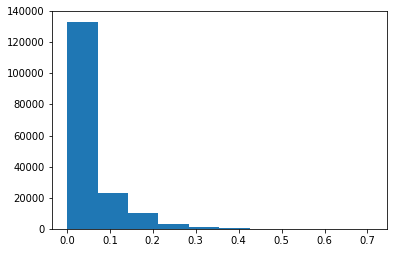

In [23]:
plt.hist(priorizados['score'])
plt.show()

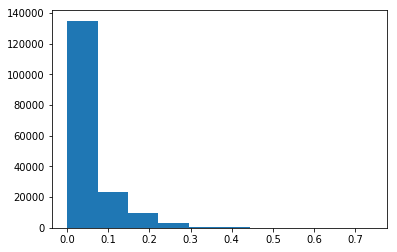

In [24]:
plt.hist(control['score'])
plt.show()

In [25]:
data_202005['decil'] = np.where(data_202005['score'] <= 0.012484, 1,
                                np.where((data_202005['score'] > 0.012484) & (data_202005['score'] <= 0.024382), 2,
                                        np.where((data_202005['score'] > 0.024382) & (data_202005['score'] <= 0.041522), 3,
                                                np.where((data_202005['score'] > 0.041522) & (data_202005['score'] <= 0.074997), 4, 5))))

In [26]:
priorizados['decil'] = np.where(priorizados['score'] <= 0.012484, 1,
                                np.where((priorizados['score'] > 0.012484) & (priorizados['score'] <= 0.024382), 2,
                                        np.where((priorizados['score'] > 0.024382) & (priorizados['score'] <= 0.041522), 3,
                                                np.where((priorizados['score'] > 0.041522) & (priorizados['score'] <= 0.074997), 4, 5))))

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
control['decil'] = np.where(control['score'] <= 0.012484, 1,
                                np.where((control['score'] > 0.012484) & (control['score'] <= 0.024382), 2,
                                        np.where((control['score'] > 0.024382) & (control['score'] <= 0.041522), 3,
                                                np.where((control['score'] > 0.041522) & (control['score'] <= 0.074997), 4, 5))))

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
print(data_202005['decil'].value_counts())
print(data_202005['decil'].value_counts()/len(data_202005))

1    121600
5     73103
2     62707
3     45149
4     40404
Name: decil, dtype: int64
1    0.354557
5    0.213151
2    0.182839
3    0.131644
4    0.117809
Name: decil, dtype: float64


In [29]:
print(priorizados['decil'].value_counts())
print(priorizados['decil'].value_counts()/len(priorizados))

1    60663
5    36473
2    31407
3    22658
4    19985
Name: decil, dtype: int64
1    0.354369
5    0.213061
2    0.183467
3    0.132359
4    0.116744
Name: decil, dtype: float64


In [30]:
print(control['decil'].value_counts())
print(control['decil'].value_counts()/len(control))

1    60937
5    36630
2    31300
3    22491
4    20419
Name: decil, dtype: int64
1    0.354745
5    0.213242
2    0.182213
3    0.130931
4    0.118869
Name: decil, dtype: float64


In [32]:
vars_final = ['id_cliente','grupo_piloto','score']
base_final = data_202005[vars_final]

In [35]:
base_final.head()

,id_cliente,grupo_piloto,score
0,101658533836834602,priorizado,0.010571
1,102652295910031501,priorizado,0.307250
2,102652297807662901,priorizado,0.239532
3,102652298880182901,control,0.088835
4,102652303050781401,priorizado,0.017483


In [36]:
base_final.grupo_piloto.value_counts()

control       171777
priorizado    171186
Name: grupo_piloto, dtype: int64

In [37]:
base_final.to_parquet("s3://adl-refined-dev-popular/parquet/TC_adquisicion/score_preaprobados_202007",engine='pyarrow', index=False)

In [ ]:
# 	probs
# decil_probs	
# 0	0.000625
# 1	0.012490
# 2	0.024390
# 3	0.041525
# 4	0.074997

In [ ]:
# probs
# decil_probs	
# 0	0.012484
# 1	0.024382
# 2	0.041522
# 3	0.074997
# 4	0.561887

In [ ]:
grupo_piloto

In [ ]:
data_202005.head()